# Load and pickle Patch-seq data

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

sns.set_style('ticks')

In [2]:
# META DATA

meta = pd.read_csv('../data/m1_patchseq_meta_data.csv', sep='\t')

cells = meta['Cell'].values

layers = meta['Targeted layer'].values.astype('str')
cre  = meta['Cre'].values
yields = meta['Yield (pg/µl)'].values
yields[yields=='?'] = np.nan
yields = yields.astype('float')
depth = meta['Soma depth (µm)'].values
depth[depth=='Slice Lost'] = np.nan
depth = depth.astype(float)
thickness = meta['Cortical thickness (µm)'].values
thickness[thickness==0] = np.nan
thickness = thickness.astype(float)
traced = meta['Traced'].values=='y'
exclude = meta['Exclusion reasons'].values.astype(str)
exclude[exclude=='nan'] = ''

mice_names = meta['Mouse'].values
mice_ages = meta['Mouse age'].values
mice_cres = np.array([c if c[-1]!='+' and c[-1]!='-' else c[:-1] for c in meta['Cre'].values])
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print('Number of cells with measured depth:    ', np.sum(~np.isnan(depth)))
print('Number of cells with measured thickness:', np.sum(~np.isnan(thickness)))
print('Number of reconstructed cells:          ', np.sum(traced))

sliceids = meta['Slice'].values
a,b = np.unique(sliceids, return_counts=True)
assert np.all(b<=2)
print('Number of slices with two cells:        ', np.sum(b==2))

# Some consistency checks
assert np.all([np.unique(meta['Date'].values[mice_names==m]).size==1 for m in mice_names])
assert np.all([np.unique(meta['Mouse age'].values[mice_names==m]).size==1 for m in mice_names])
assert np.all([np.unique(meta['Mouse gender'].values[mice_names==m]).size==1 for m in mice_names])
assert np.all([np.unique(meta['Mouse genotype'].values[mice_names==m]).size==1 for m in mice_names])
assert np.all([np.unique(meta['Mouse'].values[sliceids==s]).size==1 for s in sliceids])

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


In [3]:
# Generate mice ids

# alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# mid = ''.join([alphabet[i] for i in np.random.choice(26,5)])
# if mid not in mice_names:
#     print('mouse_'+mid)

In [4]:
# Compute mice ages

# from datetime import date

# d0 = date(2020, 3, 16)
# d1 = date(2019, 12, 20)
# delta = d1 - d0
# print(delta.days)

In [5]:
# Assign layers

# with np.errstate(invalid='ignore'):
#     estimatedLayers = layers.copy()
#     estimatedLayers[np.arange(estimatedLayers.size)] = 0
#     normdepth = depth/thickness
#     estimatedLayers[normdepth < 0.07] = '1'
#     estimatedLayers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
#     estimatedLayers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
#     estimatedLayers[normdepth > 0.73] = '6'
    
# print('\n'.join(estimatedLayers[-9:]))

In [6]:
# meta2 = pd.read_excel('../../BICCN patch-seq data/M1/meta/obsolete/Reconstruction list.xlsx')

# s0 = [s[6:10]+s[:2]+s[3:5]+'_sample_' for s in meta2.values[2:,0]]
# s1 = [s.split()[1] if len(s.split())>1 else s[6:].strip() for s in meta2.values[2:,2]]
# ss = [s0[i]+s1[i] for i in range(len(s0))]
# ss = np.array(ss)

# assert np.all(np.isin(ss, cells))
# assert np.all(np.isin(cells, ss))

# slicenum = [s[5:].strip() if isinstance(s,str) else np.nan for s in meta2.values[2:,1]]
# slicenum = np.array(slicenum).astype(float)
# slicenum_reordered = slicenum.copy()
# for i in range(slicenum.size):
#     slicenum_reordered[i] = slicenum[np.where(ss==cells[i])[0][0]]

# sliceids = [c.split('_')[0] + '_slice_' + c.split('_')[2] for c in cells]
# for i in np.where(~np.isnan(slicenum_reordered))[0]:
#     sliceids[i] = sliceids[i].split('_')[0] + '_slice_{}'.format(slicenum_reordered[i].astype(int))
# sliceids = np.array(sliceids)
# print('\n'.join(sliceids))

In [7]:
# Check that all cells on the same slice have the same cortical thickness
a,b = np.unique(sliceids, return_counts=True)
for i in np.where(b>1)[0]:
    if np.all(~np.isnan(thickness[sliceids==a[i]])) and np.unique(thickness[sliceids==a[i]]).size>1:
        for jj in np.where(sliceids==a[i])[0]:
            print(cells[jj] + '\t' + sliceids[jj] + '\t{:.3f}'.format(thickness[jj]))
        print('')

# Check that all cells patched on the same day with the same thickness have the same slice id
c = [meta['Date'].values[i] + '-{:.3f}'.format(meta['Cortical thickness (µm)'][i]) for i in range(1320)]
a,b = np.unique(c, return_counts=True)
for aa in a[b>1]:
    if aa[-3:] != 'nan':
        ind = (meta['Date'].values == aa[:10]) & (
            np.isclose(meta['Cortical thickness (µm)'].values, float(aa[-8:])))
        if np.unique(sliceids[ind]).size > 1:
            for jj in np.where(ind)[0]:
                print(cells[jj] + '\t' + sliceids[jj] + '\t{:.3f}'.format(thickness[jj]))
            print('')

In [8]:
# TEMP: CREATE INTRON TABLES

# data_exons = pd.read_csv('../../BICCN patch-seq data/M1/rnaseq/revision/final_patch_seq_allcells_exon_allreads-revision_no_duplicates.txt', 
#                    sep='\t', na_filter=False, index_col=0)
# reorder = [np.where(data_exons.columns==c)[0][0] for c in cells]
# data_exons = data_exons[data_exons.columns[reorder]]

# data_both = pd.read_csv('../../BICCN patch-seq data/M1/rnaseq/revision/final_patch_seq_allcells_intronexon_allreads-revision_no_duplicates.txt', 
#                    sep='\t', na_filter=False, index_col=0)
# reorder = [np.where(data_both.columns==c)[0][0] for c in cells]
# data_both = data_both[data_both.columns[reorder]]

# assert(all(data_exons.columns == data_both.columns))
# data_both = data_both[data_both.index.isin(data_exons.index)]
# assert(all(data_exons.index == data_both.index))

# data_introns = data_both - data_exons
# data_introns.values[data_introns.values<0]=0
# assert(np.all(data_introns.values>=0))

# data_exons.to_csv('../../BICCN patch-seq data/M1/preprocessed_data/m1_patchseq_exon_counts.csv.gz')
# data_introns.to_csv('../../BICCN patch-seq data/M1/preprocessed_data/m1_patchseq_intron_counts.csv.gz')

In [9]:
# TRANSCRIPTOMIC DATA: read counts

data_exons = pd.read_csv('../data/m1_patchseq_exon_counts.csv.gz', 
                   na_filter=False, index_col=0)
exonCounts = data_exons.values.transpose()
exonCounts = scipy.sparse.csr_matrix(exonCounts)
assert(all(cells==data_exons.columns))
genes = np.array(data_exons.index)

print('Count matrix shape (exon):  ', exonCounts.shape)

data_introns = pd.read_csv('../data/m1_patchseq_intron_counts.csv.gz', 
                   na_filter=False, index_col=0)
intronCounts = data_introns.values.transpose()
intronCounts = scipy.sparse.csr_matrix(intronCounts)
assert(all(cells==data_introns.columns))
assert(all(data_introns.index==data_exons.index))

print('Count matrix shape (intron):', intronCounts.shape)

Count matrix shape (exon):   (1329, 42466)
Count matrix shape (intron): (1329, 42466)


In [10]:
# TRANSCRIPTOMIC DATA: gene lengths

# data = pd.read_csv('../../BICCN patch-seq data/M1/rnaseq/gene_lengths.txt', sep='\t')

# data['exon_bp'] = data.groupby('GeneID')['exon_bp'].transform('sum')
# data['intron_bp'] = data.groupby('GeneID')['intron_bp'].transform('sum')
# data['gene_bp'] = data.groupby('GeneID')['gene_bp'].transform('sum')
# data = data.drop_duplicates()

# data = data[data['GeneID'].isin(genes)]
# data.set_index('GeneID', inplace=True)
# data = data.reindex(genes)

# data.to_csv('../../BICCN patch-seq data/M1/preprocessed_data/gene_lengths.txt')

In [11]:
# TRANSCRIPTOMIC DATA: gene lengths

data = pd.read_csv('../data/gene_lengths.txt')
assert(all(data['GeneID']==genes))
exonLengths = data['exon_bp'].values
intronLengths = data['intron_bp'].values

In [12]:
# EPHYS DATA

ephysData = pd.read_csv('../data/m1_patchseq_ephys_features.csv')
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData['cell id'].values
ephysData = ephysData.values[:,1:].astype('float')
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array([names2ephys[c] if c in names2ephys else ephysData[0]*np.nan for c in cells])

print('Number of cells with ephys data:', np.sum(np.isin(cells, ephysCells)))

assert(np.sum(~np.isin(ephysCells,cells))==0)

Number of cells with ephys data: 1328


In [13]:
# MORPH DATA

morphometrics = pd.read_csv('../data/m1_patchseq_morph_features.csv')

names = morphometrics['cell id'].values
morphDataRaw = morphometrics.values[:,1:-2].astype(float)
morphData = np.zeros((cells.size, morphDataRaw.shape[1])) * np.nan
for i,c in enumerate(cells):
    if c in names:
        morphData[i,:] = morphDataRaw[names==c,:]
morphDataNames = morphometrics.columns[1:-2]

assert(names.size == np.sum(np.isin(cells, names)))

print('Number of traced cells:', np.sum(meta['Traced']=='y'))
print('Number of cells with morphometrics:', names.size)

zProfiles = pd.read_csv('../data/m1_patchseq_morph_zprofiles.csv')
names = zProfiles['cell id'].values
zProfileData = zProfiles.values[:,1:]

zProfiles = np.zeros((cells.size, 20)) * np.nan
for i,c in enumerate(cells):
    if c in names:
        zProfiles[i,:] = zProfileData[names==c,:]

Number of traced cells: 646
Number of cells with morphometrics: 646


In [14]:
# EXPORT

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = houstonData(exonCounts=exonCounts, intronCounts=intronCounts,
                 cells=cells, genes=genes, layers=layers, cre=cre, 
                 yields=yields, traced=traced, depth=depth,
                 ephys=ephysData, ephysNames=ephysNames,
                 exclude=exclude, thickness=thickness, mice_ages=mice_ages, mice_cres=mice_cres,
                 morphometrics=morphData, morphometricsNames=morphDataNames, zProfiles=zProfiles,
                 exonLengths=exonLengths, intronLengths=intronLengths) 

pickle.dump(m1, open('../data/processed/rnaseq/m1.pickle', 'wb'))

## Some checks

In [15]:
# Check sorting in the spreadsheet

import re
def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in _nsre.split(s)]    
z = dict(zip(sorted(cells, key=natural_sort_key), cells))
np.all([z[a]==a for a in z])

True

<IPython.core.display.Javascript object>


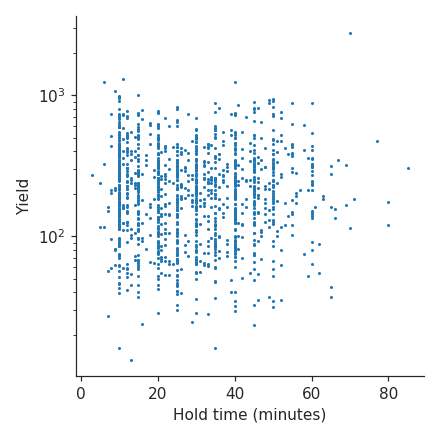

Spearman rho: -0.01


In [16]:
meta = pd.read_csv('../data/m1_patchseq_meta_data.csv', sep='\t')

m = meta['Hold Time (min)'].values
y = meta['Yield (pg/µl)'].values
y[y=='?'] = np.nan
y = y.astype('float')

plt.figure(figsize=(4,4))
plt.scatter(m,y,s=1)
plt.yscale('log')
plt.xlabel('Hold time (minutes)')
plt.ylabel('Yield')
sns.despine()
plt.tight_layout()

rho = scipy.stats.spearmanr(m[~np.isnan(y)&~np.isnan(m)],np.log(y[~np.isnan(y)&~np.isnan(m)]))[0]
print('Spearman rho: {:.2f}'.format(rho))